In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding",  # this disables constant folding
#     "--xla_cpu_use_thunk_runtime=false",
# )
from desc import set_device
set_device("gpu")

In [2]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+413.gfb2a5c554.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 9.98 GB available memory.


In [5]:
eq0 = desc.io.load(
    "./ISLAND_STUFF/LANDREMAN2021/eq-org/eq-org-landreman2021-island-L16M16N4.h5"
)
eq_opt = eq0.copy()
eq_opt.change_resolution(L=8, M=4, N=4)
eq_opt.change_resolution(L=16, M=16, N=4, L_grid=24, M_grid=24, N_grid=8)
eq_opt.xsection = eq_opt.get_surface_at(zeta=0.0)
eq_opt.surface = eq_opt.get_surface_at(rho=1.0)
eq_opt.axis = eq_opt.get_axis()

/CODES/DESC/desc/utils.py:572: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(msg, err)


In [6]:
w_force = 1000
w_section = 100
w_surface = 1
obj2 = ObjectiveFunction(
    [
        ForceBalance(eq_opt, weight=w_force),
        FixSectionR(eq_opt, remove_optimizables=False, weight=w_section),
        FixSectionZ(eq_opt, remove_optimizables=False, weight=w_section),
        FixBoundaryR(eq_opt, remove_optimizables=False, weight=w_surface),
        FixBoundaryZ(eq_opt, remove_optimizables=False, weight=w_surface),
    ]
)

In [7]:
cons = (FixPressure(eq_opt), FixPsi(eq_opt), FixCurrent(eq_opt), FixLambdaGauge(eq_opt), FixSheetCurrent(eq_opt))
cons = maybe_add_self_consistency(eq_opt, cons)

In [8]:
eq_opt.solve(objective=obj2, constraints=cons, verbose=3, ftol=1e-3, maxiter=1000);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 825 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Timer: Objective build = 2.25 sec
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Building objective: lambda gauge
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 212 ms
Timer: LinearConstraintProjection build = 5.53 sec
Number of parameters: 2061
Number of objectives: 6196
Timer: Initializing the optimization = 8.40 sec

Starting optimization
Using method: lsq-exact
   It

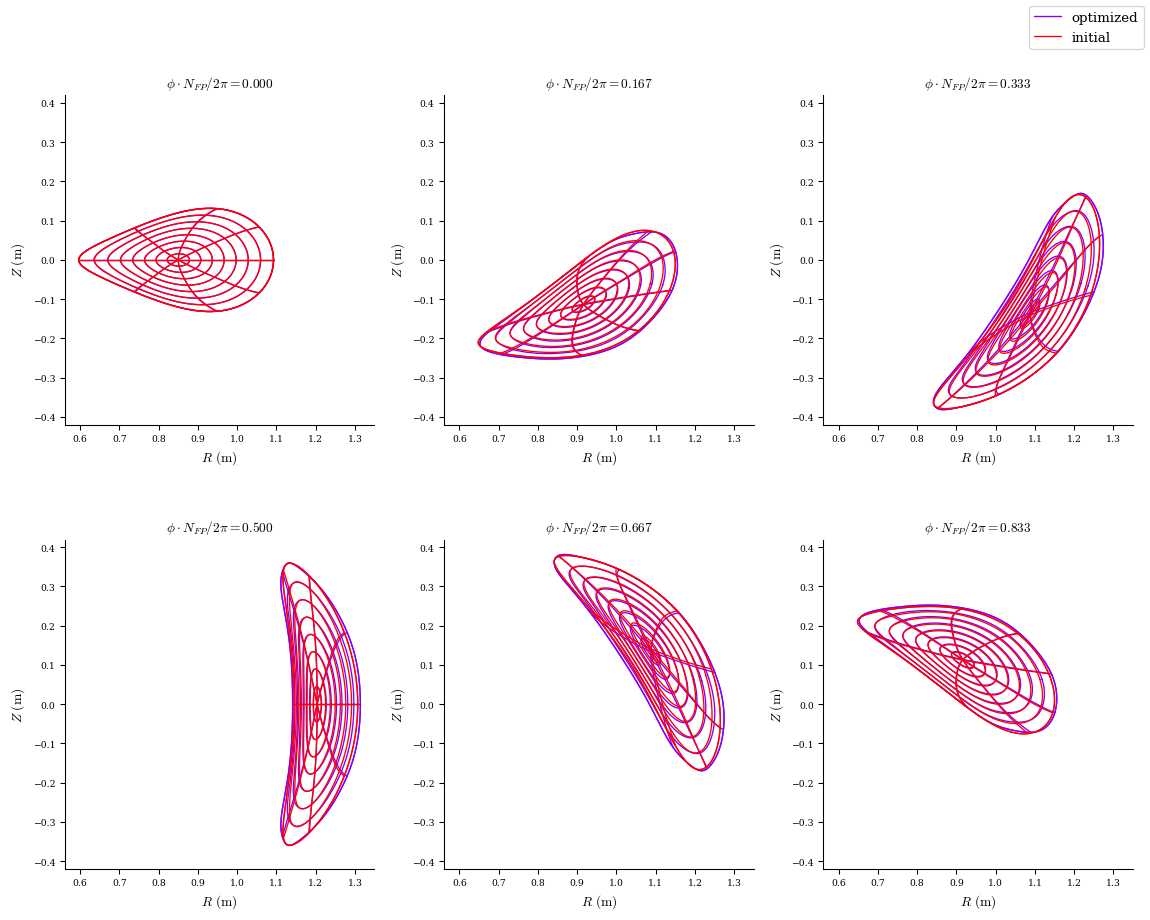

In [14]:
plot_comparison([eq_opt, eq0], labels=["optimized", "initial"]);

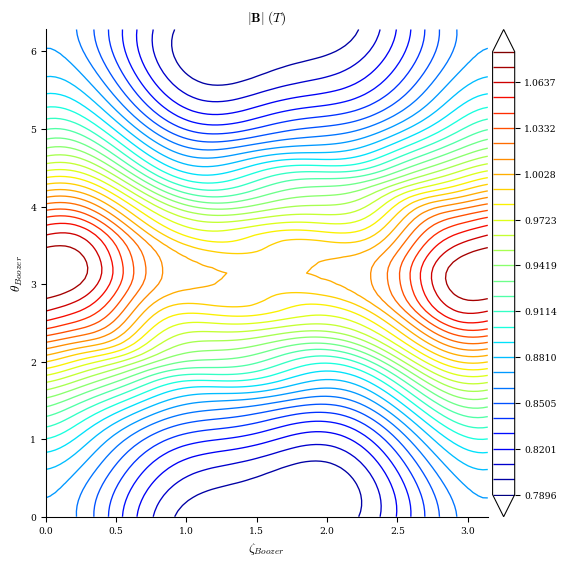

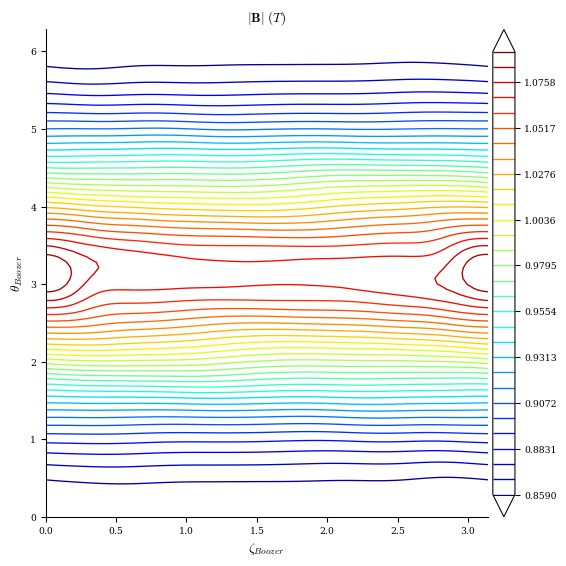

In [15]:
plot_boozer_surface(eq_opt)
plot_boozer_surface(eq0);

In [20]:
def plot_field_lines(field, equ, ntransit=200, nrho=9, size=0.4, outside=False):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    if outside:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, 2))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
        rmax = np.max(r0)
        rmin = np.min(r0)
        r0 = np.linspace(rmin, rmax + (rmax-rmin)*0.05, nrho)
        z0 = np.zeros_like(r0)
    else:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, nrho))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
    fig, ax = plot_surfaces(equ)
    fig, ax = poincare_plot(
        field,
        r0,
        z0,
        NFP=equ.NFP,
        ax=ax,
        color="k",
        size=size,
        ntransit=ntransit,
        bounds_R=(0.5, 1.5),
        bounds_Z=(-0.7, 0.7),
    )
    return fig, ax

def plot_init_coils_modular(equ, ncoils=3, r_over_a=3.5):
    coilset = initialize_modular_coils(
        equ, num_coils=ncoils, r_over_a=r_over_a
    ).to_FourierXYZ()
    fig = plot_3d(equ, "|B|")
    fig = plot_coils(coilset, fig=fig)
    return fig

In [21]:
def optimize_coils_regcoil(surf, equ, num_coils=16, return_k=False):
    # create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
    surface_current_field = FourierCurrentPotentialField.from_surface(
        surf,
        I=0,
        # manually setting G to value needed to provide the equilibrium's toroidal flux,
        # though this is not necessary as it gets set automatically inside the solve_regularized_surface_current function
        G=np.asarray(
            [
                -equ.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0]
                / mu_0
                * 2
                * np.pi
            ]
        ),
        # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
        sym_Phi="sin",
    )

    surface_current_field.change_Phi_resolution(M=12, N=12)

    # create the evaluation grid (where Bn will be minimized on plasma surface)
    # and source grid (discretizes the source K for Biot-Savart and where |K| will be penalized on winding surface)
    Megrid = 20
    Negrid = 20
    Msgrid = 20
    Nsgrid = 20

    eval_grid = LinearGrid(M=Megrid, N=Negrid, NFP=equ.NFP, sym=False)
    # ensure that sym=False for source grid so the field evaluated from the surface current is accurate
    # (i.e. must evaluate source over whole surface, not just the symmetric part)
    # NFP>1 is ok, as we internally will rotate the source through the field periods to sample entire winding surface
    sgrid = LinearGrid(M=Msgrid, N=Nsgrid, NFP=equ.NFP, sym=False)

    lambda_regularization = np.append(np.array([0]), np.logspace(-30, 1, 20))

    # solve_regularized_surface_current method runs the REGCOIL algorithm
    fields, data = solve_regularized_surface_current(
        surface_current_field,  # the surface current field whose geometry and Phi resolution will be used
        eq=equ,  # the Equilibrium object to minimize Bn on the surface of
        source_grid=sgrid,  # source grid
        eval_grid=eval_grid,  # evaluation grid
        current_helicity=(
            1*surface_current_field.NFP,
            -1,
        ),  # pair of integers (M_coil, N_coil), determines topology of contours (almost like  QS helicity),
        #  M_coil is the number of times the coil transits poloidally before closing back on itself
        # and N_coil is the toroidal analog (if M_coil!=0 and N_coil=0, we have modular coils, if both M_coil
        # and N_coil are nonzero, we have helical coils)
        # we pass in an array to perform scan over the regularization parameter (which we call lambda_regularization)
        # to see tradeoff between Bn and current complexity
        lambda_regularization=lambda_regularization,
        # lambda_regularization can also be just a single number in which case no scan is performed
        vacuum=True,  # this is a vacuum equilibrium, so no need to calculate the Bn contribution from the plasma currents
        regularization_type="regcoil",
        chunk_size=40,
    )
    surface_current_field = fields[
        0
    ]  # fields is a list of FourierCurrentPotentialField objects

    if return_k:
        return surface_current_field
    else:
        coilset = surface_current_field.to_CoilSet(num_coils=num_coils, stell_sym=True)
        return coilset

In [22]:
regcoil = 1
return_k = 1
if regcoil:
    # create the constant offset surface
    surf2 = eq_opt.surface.constant_offset_surface(
        offset=0.25,  # desired offset
        M=16,  # Poloidal resolution of desired offset surface
        N=16,  # Toroidal resolution of desired offset surface
        grid=LinearGrid(M=32, N=32, NFP=eq_opt.NFP),
    )  # grid of points on base surface to evaluate unit normal and find points on offset surface,
    # generally should be twice the desired resolution
    if return_k:
        optimized_coilset2 = optimize_coils_regcoil(
            surf2, eq_opt, num_coils=8, return_k=True
        )
    else:
        optimized_coilset2 = optimize_coils_regcoil(surf2, eq_opt, num_coils=8)
else:
    coilset0 = initialize_modular_coils(eq_opt, num_coils=3, r_over_a=4).to_FourierXYZ()
    optimized_coilset2 = optimize_coils(eq_opt, coilset0=coilset0, curvature=True)

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 4.52216e-08
min Bnormal = 1.57558e-18 (T)
Max Bnormal = 1.12043e-06 (T)
Avg Bnormal = 2.68417e-07 (T)
min Bnormal = 1.67825e-18 (unitless)
Max Bnormal = 1.19344e-06 (unitless)
Avg Bnormal = 2.85907e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 4.52216e-08
min Bnormal = 1.57558e-18 (T)
Max Bnormal = 1.12043e-06 (T)
Avg Bnormal = 2.68417e-07 (T)
min Bnormal = 1.67825e-18 (unitless)
Max Bnormal = 1.19344e-06 (unitless)
Avg Bnormal = 2.85907e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 4.52216e-08
m

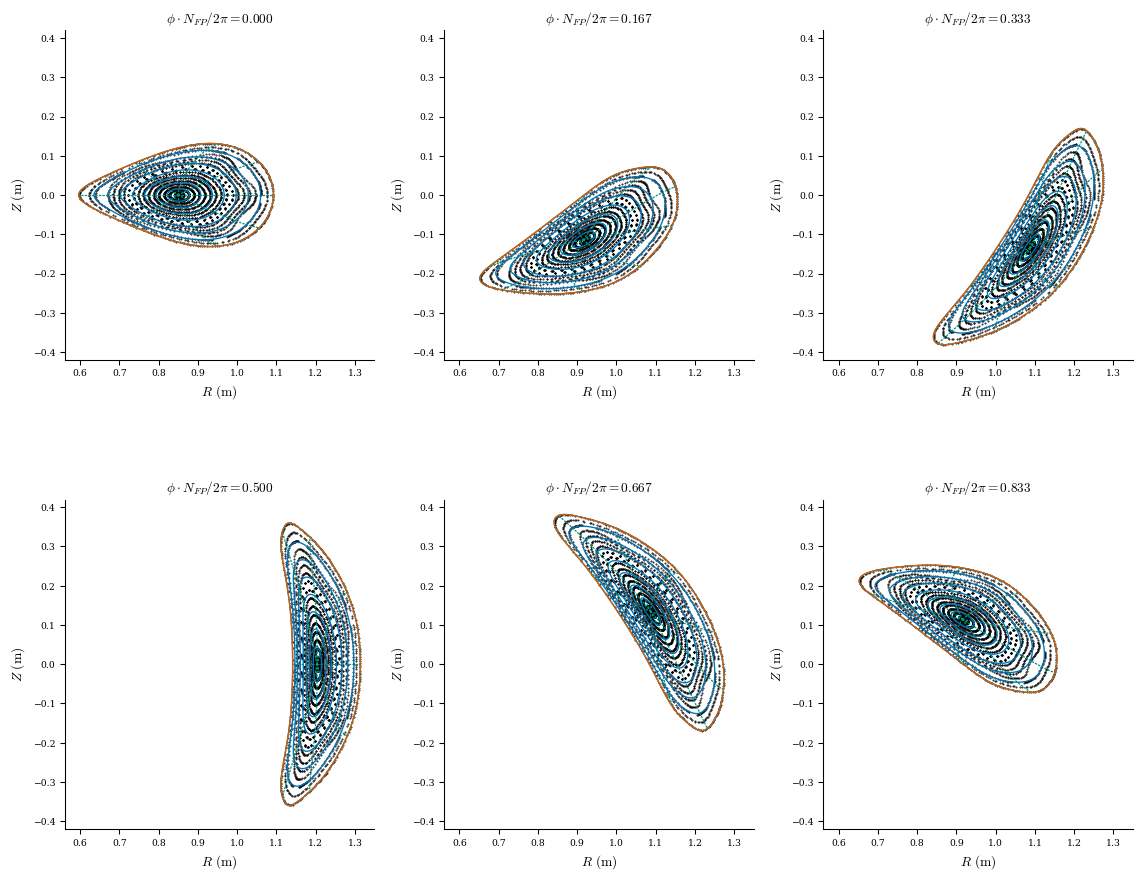

In [23]:
fig, ax = plot_field_lines(
    optimized_coilset2, eq_opt, nrho=18, ntransit=200, size=0.2, outside=False
)
plt.show()
# fig.savefig(
#     f"plot-landreman2021-optimize-poincare-L{eq_opt.L}M{eq_opt.M}N{eq_opt.N}.png", dpi=1000
# )

(<Figure size 384.076x384.076 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\iota ~(~)$'>)

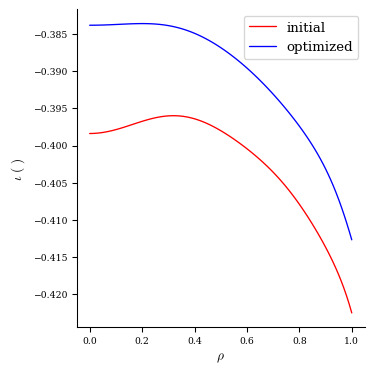

In [19]:
fig, ax = plot_1d(eq0, "iota", label="initial", color="red")
plot_1d(eq_opt, "iota", ax=ax, label="optimized", color="blue")
# plt.savefig(
#     f"plot-landreman2021-iota-L{eq_opt.L}M{eq_opt.M}N{eq_opt.N}.png", dpi=400
# )

In [17]:
regcoil = 1
return_k = 1
if regcoil:
    # create the constant offset surface
    surf2 = eq0.surface.constant_offset_surface(
        offset=0.25,  # desired offset
        M=16,  # Poloidal resolution of desired offset surface
        N=16,  # Toroidal resolution of desired offset surface
        grid=LinearGrid(M=32, N=32, NFP=eq0.NFP),
    )  # grid of points on base surface to evaluate unit normal and find points on offset surface,
    # generally should be twice the desired resolution
    if return_k:
        optimized_coilset2 = optimize_coils_regcoil(
            surf2, eq0, num_coils=8, return_k=True
        )
    else:
        optimized_coilset2 = optimize_coils_regcoil(surf2, eq0, num_coils=8)
else:
    coilset0 = initialize_modular_coils(eq0, num_coils=3, r_over_a=4).to_FourierXYZ()
    optimized_coilset2 = optimize_coils(eq0, coilset0=coilset0, curvature=True)

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 8.08508e-11
min Bnormal = 6.77562e-19 (T)
Max Bnormal = 6.93535e-08 (T)
Avg Bnormal = 1.01661e-08 (T)
min Bnormal = 6.92668e-19 (unitless)
Max Bnormal = 7.08996e-08 (unitless)
Avg Bnormal = 1.03927e-08 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 8.08508e-11
min Bnormal = 5.57875e-19 (T)
Max Bnormal = 6.93535e-08 (T)
Avg Bnormal = 1.01661e-08 (T)
min Bnormal = 5.70312e-19 (unitless)
Max Bnormal = 7.08996e-08 (unitless)
Avg Bnormal = 1.03927e-08 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 8.08508e-11
m

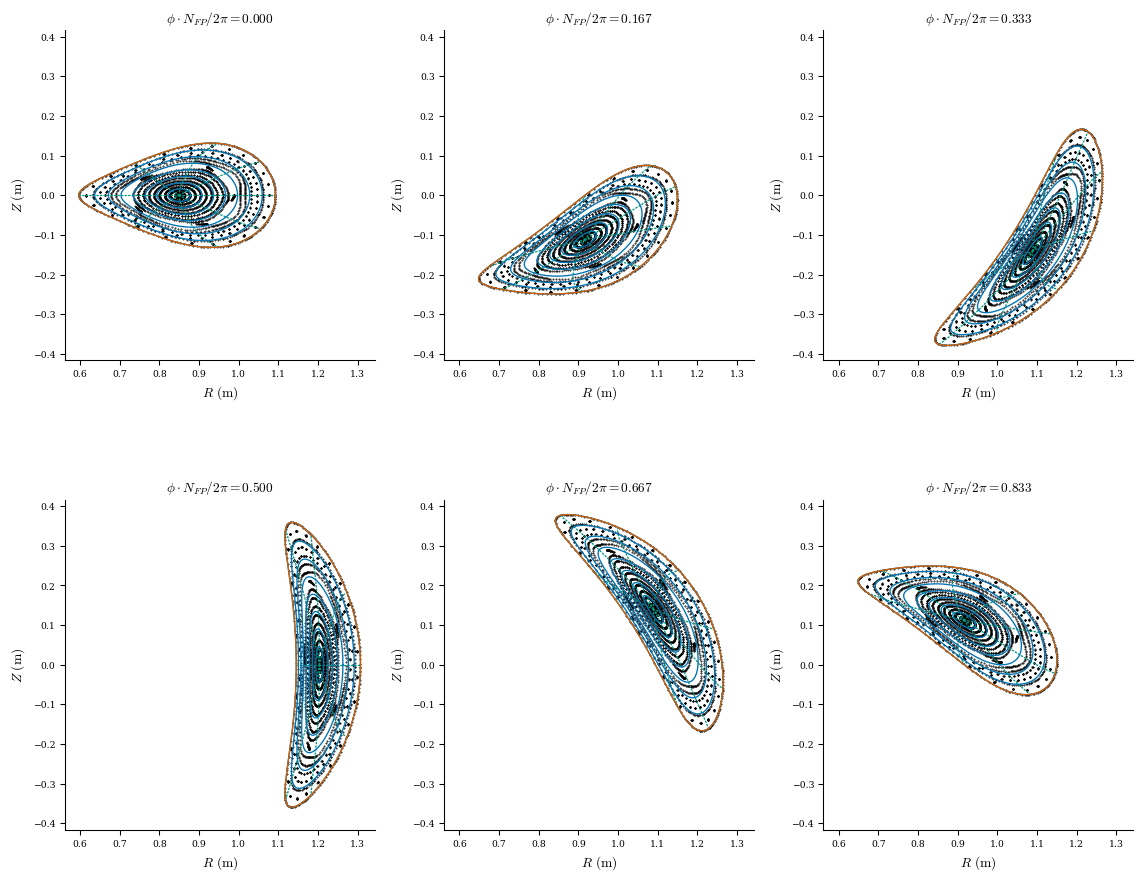

In [18]:
fig, ax = plot_field_lines(
    optimized_coilset2, eq0, nrho=18, ntransit=200, size=0.2, outside=False
)
plt.show()